This is a language analysis notebook.

In [23]:
def lang_confidence_score(word_counts: dict[str, float], language_words_with_frequency: dict[str, float]) -> float:
    if(len(word_counts) == 0):
        return 1
    number_of_words = 0
    for val in word_counts.items():
        number_of_words += val[1]
    deviation = 0
    for word in word_counts:
        if(word not in word_counts or word not in language_words_with_frequency): 
            # Dictionary miss - we impose the most severe penalty.
            deviation += 1
        else:
            # Word found in dictionary - we impose penalty based on difference of frequency in text and frequency in dictionary.
            deviation += (word_counts[word] / number_of_words - language_words_with_frequency[word])**2
    return 1 - deviation / len(word_counts)


In [24]:
import wordfreq 

def create_lang_dict(size, language):
    words = wordfreq.top_n_list(language, size, wordlist='best')
    d = {w: wordfreq.word_frequency(w, language) for w in set(words)}
    return d


en_dict = create_lang_dict(1000, 'en')
fr_dict = create_lang_dict(1000, 'fr')
de_dict = create_lang_dict(1000, 'de')

Create large article dictionary

In [25]:
import json
import os
from pathlib import Path

p = Path('./word-counts.json')

if(p.exists()):
    p.unlink()

%run wikiscraper.py --count-words Ash

with open('./word-counts.json', 'r') as file:
    large_article = json.load(file)



Output below was generated using an article originally published on https://bulbapedia.bulbagarden.net/wiki.
It is licensed under BY-NC-SA.



Take article with low fr and de scores

In [ ]:
p = Path('./word-counts.json')

lowest_score = 1

for i in range(0, 50):

    if(p.exists()):
        p.unlink()

    %run wikiscraper.py --count-words 'Special:Random'

    with open('./word-counts.json', 'r') as file:
        potential_article = json.load(file)
    
    if(len(potential_article) >= 50):
        score = lang_confidence_score(potential_article, en_dict)
        if(score < lowest_score):
            lowest_score = score
            interesting_article = potential_article

# Verify that the score is low

print(lang_confidence_score(interesting_article, en_dict))
print(lang_confidence_score(interesting_article, fr_dict))
print(lang_confidence_score(interesting_article, de_dict))


Output below was generated using an article originally published on https://bulbapedia.bulbagarden.net/wiki.
It is licensed under BY-NC-SA.

Output below was generated using an article originally published on https://bulbapedia.bulbagarden.net/wiki.
It is licensed under BY-NC-SA.

Output below was generated using an article originally published on https://bulbapedia.bulbagarden.net/wiki.
It is licensed under BY-NC-SA.

Output below was generated using an article originally published on https://bulbapedia.bulbagarden.net/wiki.
It is licensed under BY-NC-SA.

Output below was generated using an article originally published on https://bulbapedia.bulbagarden.net/wiki.
It is licensed under BY-NC-SA.

Output below was generated using an article originally published on https://bulbapedia.bulbagarden.net/wiki.
It is licensed under BY-NC-SA.

Output below was generated using an article originally published on https://bulbapedia.bulbagarden.net/wiki.
It is licensed under BY-NC-SA.

Output below 

Create english, french and german dictionaries based on classic literature

In [27]:
def text_to_dict(book_path):
    with open(book_path, 'r') as file:
        text_content = file.read()
    text_content = ''.join(list(map(lambda c: c.lower() if (c.isalpha() or c == ' ') else ' ', text_content)))
    
    counter: dict[str, int] = {}
    for word in text_content.split():
        counter[word] = counter.get(word, 0) + 1
    return counter


In [28]:
frankenstein_dict = text_to_dict('./frankenstein.txt')
faust_dict = text_to_dict('./faust.txt')
candide_dict = text_to_dict('./candide.txt')

Create DataFrame with all 15 combinations

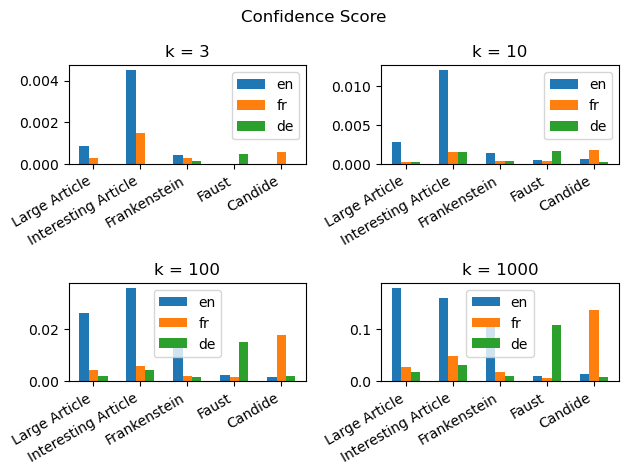

In [29]:
import numpy as np
import matplotlib.pyplot as plt

texts = [large_article, interesting_article, frankenstein_dict, faust_dict, candide_dict]
labels = ['Large Article', 'Interesting Article', 'Frankenstein', 'Faust', 'Candide']
languages = ['en', 'fr', 'de']

fig, axes = plt.subplots(2, 2)
axes = axes.flatten()

for idx, k in enumerate([3, 10, 100, 1000]):
    matrix = np.empty([len(texts), len(languages)])
    for i, t in enumerate(texts):
        for j, l in enumerate(languages):
            matrix[i][j] = lang_confidence_score(t, create_lang_dict(k, l))

    x = np.arange(len(texts))
    width = 0.2
    ax = axes[idx]
        
    for j, l in enumerate(languages):
        ax.bar(x + j*width, matrix[:, j], width, label=l)
        
    ax.set_xticks(x + width)
    ax.set_xticklabels(labels, rotation = 30, ha='right')
    ax.set_title(f'k = {k}')
    ax.legend()

fig.suptitle('Confidence Score')
plt.tight_layout()
plt.show()


Results:
We can see that the proposed function is somewhat accurate in identifying the language of the wiki. 
For all considered k's (being the number of most common words fetched from the language's dictionary) texts score significantly higher with the dictionary of the language they are written in.
The way we define our confidence function implies that the score strictly increases as k increases. 
This is clearly confirmed by our examples, as all scores increase significantly with large k's.

All three languages perform similarly despite the confidence function relying on the inflection of the words to correctly identify matches. 